In [3]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import os, sys
import pickle as pkl
import matplotlib as mpl
import copy
from scipy import interpolate


sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")

from DLScommonTools import *
from unpackConfigurationsMK import *
from LRBv21 import *


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO

In [4]:
file_paths = {
    "V10" : os.path.join(r"C:\Users\mikek\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"),
     "V10X" : os.path.join(r"C:\Users\mikek\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc"),
     "SPR38" : os.path.join(r"C:\Users\mikek\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc")}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for design in designs:  
    eqb[design] = dict()

    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 100)

In [6]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Reference result

In [ ]:
file_write(store, "2-fix_outerloop.pkl")

In [8]:
d["Bpol"]

array([0.56089437, 0.49464505, 0.43341453, 0.37656505, 0.32328749,
       0.27279294, 0.22465924, 0.17706305, 0.1322129 , 0.07640343,
       0.03747151, 0.06446479, 0.10671182, 0.14657697, 0.18254503,
       0.21352424, 0.24025063, 0.26397445, 0.28594595, 0.30733881,
       0.32856357, 0.34959288, 0.37039415, 0.39093483, 0.41118276,
       0.43113684, 0.45084773, 0.47037098, 0.48976215, 0.50907682,
       0.52837055, 0.54768788, 0.56700794, 0.58628586, 0.60547672,
       0.62453558, 0.64341752, 0.66207763, 0.68047199, 0.69857773,
       0.71639159, 0.73391109, 0.75113373, 0.76805704, 0.78467853,
       0.80099571, 0.81700603, 0.83270466, 0.84808375, 0.86313525,
       0.8778511 , 0.89222326, 0.90624368, 0.91990429, 0.93319705,
       0.94611427, 0.95865355, 0.97081664, 0.98260535, 0.99402152,
       1.00506697, 1.01574354, 1.02605306, 1.03599735, 1.04557826,
       1.05479798, 1.06365945, 1.07216569, 1.08031971, 1.08812451,
       1.09558313, 1.10269856, 1.10947383, 1.11591194, 1.12201

In [9]:
cvar = "density"
design = "SPR38"

store = dict()
# for cvar in ["impurity_frac"]:
for cvar in ["density", "impurity_frac", "power"]:
    store[cvar] = dict()
    
    for side in ["iu", "ou"]:
    # for side in ["iu"]:
        d = eqb[design][side].copy() # Load in single profile into dictionary "d"
        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5) # Solve at these parallel positions

        if side == "iu":
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Inner has more heat flux density

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3, timeout = 20)
        
        store[cvar][side] = copy.deepcopy(results)

Solving...0.00...3.33...6.66...

C:\Users\mikek\OneDrive\Project\DLS\DLS-git\Iterate.py:69: RuntimeWarning: invalid value encountered in scalar power
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))


9.98...13.31...Complete in 4.9 seconds
Solving...0.00...6.67...13.35...20.02...26.69...Complete in 4.7 seconds
Solving...0.00...3.33...6.66...9.98...13.31...Complete in 3.7 seconds
Solving...0.00...6.67...13.35...20.02...26.69...Complete in 3.7 seconds
Solving...0.00...3.33...6.66...9.98...13.31...Complete in 7.5 seconds
Solving...0.00...6.67...13.35...20.02...26.69...Complete in 10.0 seconds


Text(0.5, 1.0, 'Inner divertor')

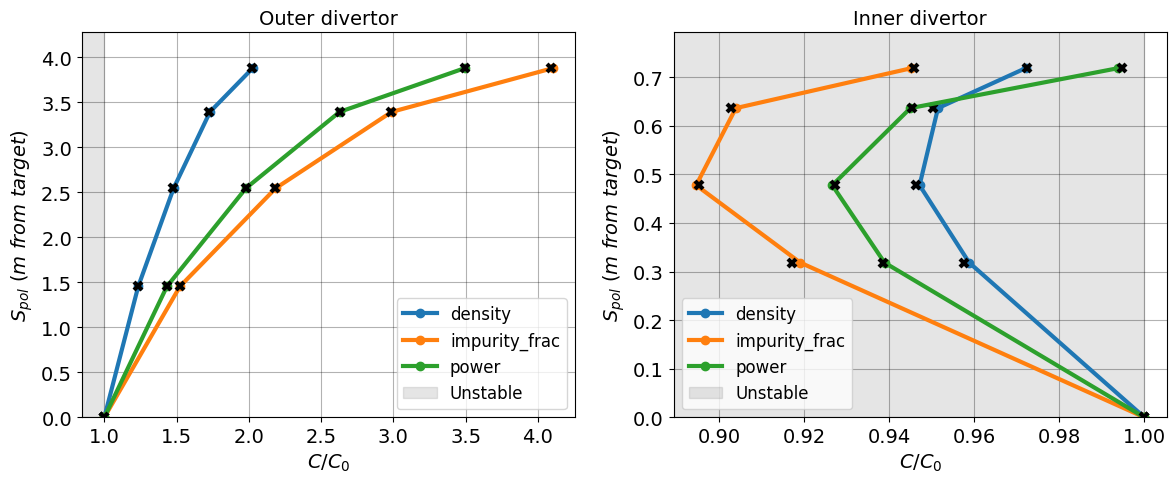

In [ ]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
ax = axes[0]

basis = "crel"

ref = file_read(r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\3-fix_init.pkl")

for k, side in enumerate(["ou", "iu"]):
    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[cvar][side].copy()
        r = ref[cvar][side].copy()
        x = o[basis]        
        xr = r[basis]
        if cvar == "power":
            x = 1/x
            xr = 1/xr
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  label = cvar)
        axes[k].plot(xr, o["SpolPlot"],  marker = "x", markersize = 6, linewidth = 0,  color = "k", markeredgewidth=3)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

Text(0.5, 1.0, 'Inner divertor')

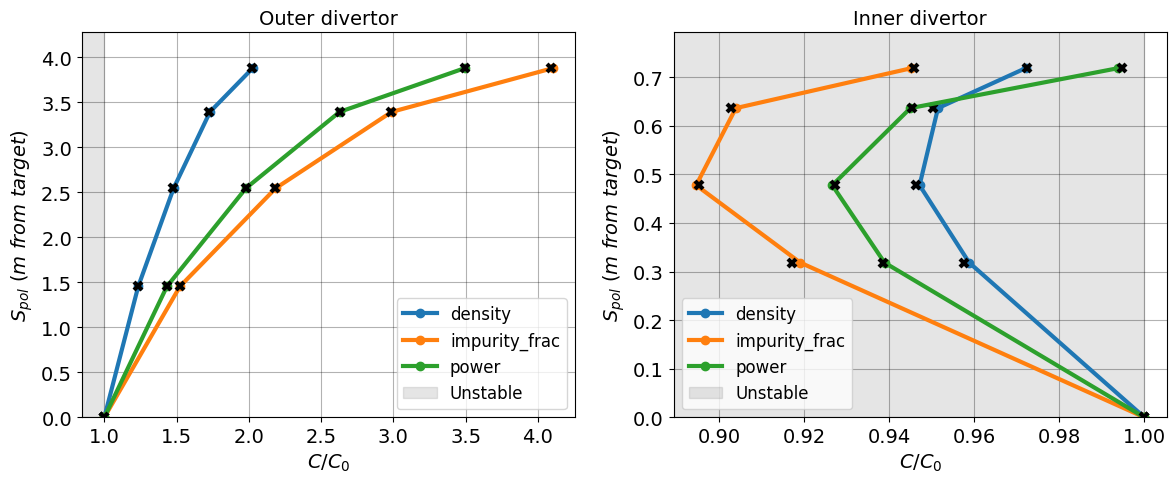

In [29]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
ax = axes[0]

basis = "crel"

ref = file_read(r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\3-fix_init.pkl")

for k, side in enumerate(["ou", "iu"]):
    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[cvar][side].copy()
        r = ref[cvar][side].copy()
        x = o[basis]        
        xr = r[basis]
        if cvar == "power":
            x = 1/x
            xr = 1/xr
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  label = cvar)
        axes[k].plot(xr, o["SpolPlot"],  marker = "x", markersize = 6, linewidth = 0,  color = "k", markeredgewidth=3)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

Text(0, 0.5, 'error1')

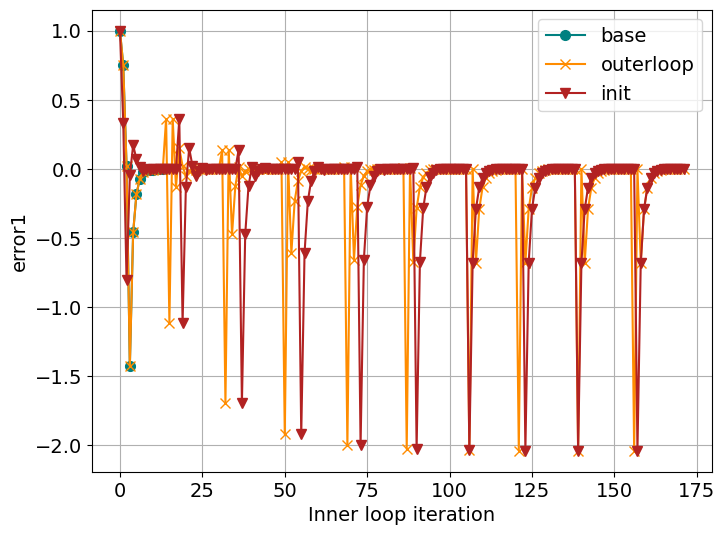

In [103]:
fig, ax = plt.subplots()

# for k, side in enumerate(["ou", "iu"]):
#     for i, cvar in enumerate(["density", "impurity_frac", "power"]):
#         o = store[cvar][side].copy()
#         ax.plot(o["logs"][0]["error1"], lw = 1)

cases = {
    "base":r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\1-baseline.pkl",
    "outerloop":r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\2-fix_outerloop.pkl",
    "init":r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\3-fix_init.pkl"}

markers = ["o", "x", "v"]
colors = ["teal", "darkorange", "firebrick"]
cvar = "power"
side = "ou"
for i, case in enumerate(cases):
    store = file_read(cases[case])
    o = store[cvar][side].copy()
    ax.plot(o["logs"][0]["error1"], lw = 1.5, label = case, ms = 7, marker = markers[i], color = colors[i])

ax.legend()
ax.set_xlabel("Inner loop iteration")
ax.set_ylabel("error1")

# Single difficult test

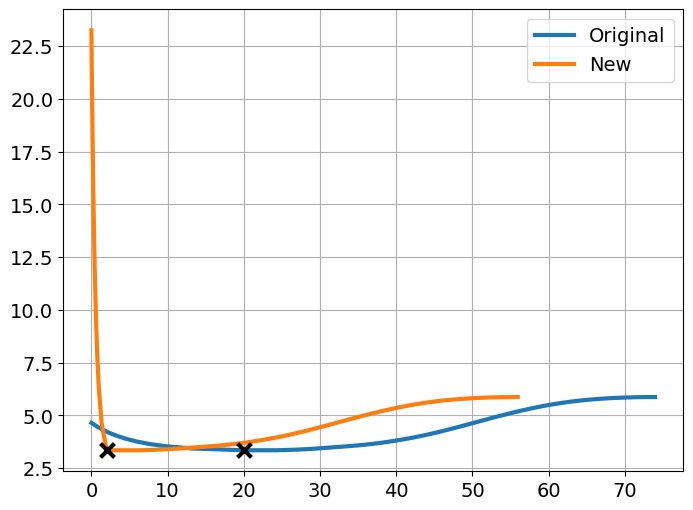

In [9]:
BxBt_scale = 0.2
Lc_scale = 0.1
design = "SPR38"
side = "iu"

d = copy.deepcopy(eqb[design][side])
constants = constants_default.copy()
radios = radios_default.copy()

Btot = d["Btot"].copy()
S = d["S"].copy()
Spol = d["Spol"].copy()
Xpoint = d["Xpoint"]
                    
d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                    
fig, ax = plt.subplots()
ax.plot(S, Btot, label = "Original")
ax.scatter(S[Xpoint], Btot[Xpoint], marker = "x", color = "k", s = 100, linewidth = 3, zorder = 10)

ax.plot(d["S"], d["Btot"], label = "New")
ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], marker = "x", color = "k", s = 100, linewidth = 3, zorder = 10)
ax.legend()

In [34]:
radios["upstreamGrid"] = True
constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint
constants["nu0"] = 1e20

# Inner has 10% of the power.
if side == "iu":
    constants["qpllu0"] = constants_default["qpllu0"] * 0.1

SparRange = [20]    
out = LRBv21(constants, radios, d, SparRange, verbosity = 2, control_variable = "power", timeout = 20)

Solving...28...

 Solving at index 28
--------------------------------
error0: 1.000E+00, Tu: 71.21, error1: 1.000E+00, cvar: 3.238E-07, lower_bound: 0.000E+00, upper_bound: 0.000E+00
error0: 1.000E+00, Tu: 71.21, error1: 2.268E+00, cvar: 3.238E-07, lower_bound: 0.000E+00, upper_bound: 0.000E+00
error0: 1.000E+00, Tu: 71.21, error1: 1.412E+00, cvar: 1.619E-07, lower_bound: 0.000E+00, upper_bound: 0.000E+00
error0: 1.000E+00, Tu: 71.21, error1: -2.998E-01, cvar: 8.095E-08, lower_bound: 0.000E+00, upper_bound: 0.000E+00
error0: 1.000E+00, Tu: 71.21, error1: 8.411E-01, cvar: 1.214E-07, lower_bound: 8.095E-08, upper_bound: 1.619E-07
error0: 1.000E+00, Tu: 71.21, error1: 3.846E-01, cvar: 1.012E-07, lower_bound: 8.095E-08, upper_bound: 1.214E-07
error0: 1.000E+00, Tu: 71.21, error1: 8.034E-02, cvar: 9.106E-08, lower_bound: 8.095E-08, upper_bound: 1.012E-07
error0: 1.000E+00, Tu: 71.21, error1: -9.859E-02, cvar: 8.601E-08, lower_bound: 8.095E-08, upper_bound: 9.106E-08
error0: 1.000E+00, Tu: 

In [24]:
out["state"].log[0]

defaultdict(list,
            {'error0': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.0],
             'error1': [1,
              6.051016628058451,
              5.323146187740624,
              3.8675726619365305,
              0.9571508740841235,
              -4.860361401033887,
              -0.9825418867984698,
              0.12579334749871846,
              -0.3857656684294513,
              -0.12051762093502222,
              0.004875906106680571,
              -0.05724610279554874,
              -0.026043080644247166,
              -0.01054833073051526,
              -0.0028272539006586974,
              0.001026469494912034,
              0.001026469494912034],
             'cvar': [3.817861348398146e-07,
              3.817861348398146e-07,
              1.908930674199073e-07,
              9.544653370995366e-08,
              4.772326685497683e-08,
              2.3861633427488414e-08,
              3.579245014123262e-08,
              4.175785849810472e-08,
       

In [ ]:
oldlogs = out["logs"][0]["error1"]

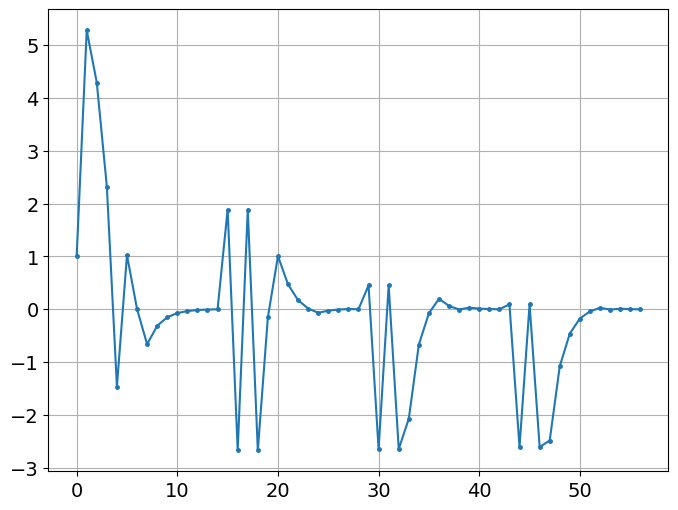

In [8]:
fig, ax = plt.subplots()

ax.plot(out["logs"][0]["error1"], marker = "o", ms = 2.5, lw = 1.5)

# Ideas dev

In [2]:
class SimulationState():
    """
    This class represents the simulation state and contains all the variables and data 
    needed to run the simulation. The state is passed around different functions, which 
    allows more of the algorithm to be abstracted away from the main function.
    """
    def __init__(self):
        pass
    
    # Update many variables
    def update(self, **kwargs):
            self.__dict__.update(kwargs)

    # Will return this if called as string
    def __repr__(self):
        return str(self.__dict__)

In [7]:
st = SimulationState()
st.update(test = 2, ohno = 2)
st.test2 = 2
st.test2 = 6
st.test=5
st

{'test': 5, 'ohno': 2, 'test2': 6}

In [19]:
test = s.cz0

In [36]:
s.update(**constants)
s

{'test': 2, 'ohno': 2, 'gamma_sheath': 7, 'qpllu0': 1000000000.0, 'nu': 1e+20, 'nu0': 1e+20, 'cz0': 0.02, 'kappa0': 2500, 'mi': 3e-27, 'echarge': 1.6000000000000002e-19, 'Tt': 0.5, 'Lfunc': <function LfuncKallenbachAr at 0x0000019336FEA170>, 'alpha': 1000}

In [28]:
constants

{'gamma_sheath': 7,
 'qpllu0': 1000000000.0,
 'nu': 1e+20,
 'nu0': 1e+20,
 'cz0': 0.02,
 'kappa0': 2500,
 'mi': 3e-27,
 'echarge': 1.6000000000000002e-19,
 'Tt': 0.5,
 'Lfunc': <function AnalyticCoolingCurves.LfuncKallenbachAr(T)>,
 'alpha': 1000}